In [1]:
from Data.preprocess_func import *
from Models.fader_network import FaderNetwork
from Models.discriminator import Discriminator
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import argparse
import os
import argparse
import torch
import sys


# Filtrer les arguments spécifiques à Jupyter
sys.argv = sys.argv[:1]  # Supprimez tous les arguments supplémentaires


# parse parameters
parser = argparse.ArgumentParser(description='Images autoencoder')
parser.add_argument("--name", type=str, default="default",
                    help="Experiment name")
parser.add_argument("--img_sz", type=int, default=256,
                    help="Image sizes (images have to be squared)")
parser.add_argument("--img_fm", type=int, default=3,
                    help="Number of feature maps (1 for grayscale, 3 for RGB)")
parser.add_argument("--n_attr", type=int, default=40,
                    help="Attributes to classify")
parser.add_argument("--instance_norm", type=bool, default=False,
                    help="Use instance normalization instead of batch normalization")
parser.add_argument("--init_fm", type=int, default=32,
                    help="Number of initial filters in the encoder")
parser.add_argument("--max_fm", type=int, default=512,
                    help="Number maximum of filters in the autoencoder")
parser.add_argument("--n_layers", type=int, default=6,
                    help="Number of layers in the encoder / decoder")
parser.add_argument("--n_skip", type=int, default=0,
                    help="Number of skip connections")
parser.add_argument("--deconv_method", type=str, default="convtranspose",
                    help="Deconvolution method")
parser.add_argument("--hid_dim", type=int, default=512,
                    help="Last hidden layer dimension for discriminator / classifier")
parser.add_argument("--dec_dropout", type=float, default=0.,
                    help="Dropout in the decoder")
parser.add_argument("--lat_dis_dropout", type=float, default=0.3,
                    help="Dropout in the latent discriminator")
parser.add_argument("--n_lat_dis", type=int, default=1,
                    help="Number of latent discriminator training steps")
parser.add_argument("--n_ptc_dis", type=int, default=0,
                    help="Number of patch discriminator training steps")
parser.add_argument("--n_clf_dis", type=int, default=0,
                    help="Number of classifier discriminator training steps")
parser.add_argument("--smooth_label", type=float, default=0.2,
                    help="Smooth label for patch discriminator")
parser.add_argument("--lambda_ae", type=float, default=1,
                    help="Autoencoder loss coefficient")
parser.add_argument("--lambda_lat_dis", type=float, default=0.0001,
                    help="Latent discriminator loss feedback coefficient")
parser.add_argument("--lambda_ptc_dis", type=float, default=0,
                    help="Patch discriminator loss feedback coefficient")
parser.add_argument("--lambda_clf_dis", type=float, default=0,
                    help="Classifier discriminator loss feedback coefficient")
parser.add_argument("--lambda_schedule", type=float, default=500000,
                    help="Progressively increase discriminators' lambdas (0 to disable)")
parser.add_argument("--v_flip", type=bool, default=False,
                    help="Random vertical flip for data augmentation")
parser.add_argument("--h_flip", type=bool, default=True,
                    help="Random horizontal flip for data augmentation")
parser.add_argument("--batch_size", type=int, default=32,
                    help="Batch size")
parser.add_argument("--ae_optimizer", type=str, default="adam,lr=0.0002",
                    help="Autoencoder optimizer (SGD / RMSprop / Adam, etc.)")
parser.add_argument("--dis_optimizer", type=str, default="adam,lr=0.0002",
                    help="Discriminator optimizer (SGD / RMSprop / Adam, etc.)")
parser.add_argument("--clip_grad_norm", type=float, default=5,
                    help="Clip gradient norms (0 to disable)")
parser.add_argument("--n_epochs", type=int, default=1000,
                    help="Total number of epochs")
parser.add_argument("--epoch_size", type=int, default=50000,
                    help="Number of samples per epoch")
parser.add_argument("--ae_reload", type=str, default="",
                    help="Reload a pretrained encoder")
parser.add_argument("--lat_dis_reload", type=str, default="",
                    help="Reload a pretrained latent discriminator")
parser.add_argument("--ptc_dis_reload", type=str, default="",
                    help="Reload a pretrained patch discriminator")
parser.add_argument("--clf_dis_reload", type=str, default="",
                    help="Reload a pretrained classifier discriminator")
parser.add_argument("--eval_clf", type=str, default="",
                    help="Load an external classifier for evaluation")
parser.add_argument("--debug", type=bool, default=False,
                    help="Debug mode (only load a subset of the whole dataset)")
params = parser.parse_args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
train_loader, valid_loader, test_loader = load_images(0, batch_size = 32, load=False)

Not load
Processing images from index 1 to 10000 ...


Processing in batches: 100%|████████████████████| 10/10 [00:08<00:00,  1.17it/s]


Processing attributes from index 1 to 10000 ...


Processing Attibute: 9998it [00:00, 213401.38it/s]

Saving attributes to attributes_0.pth ...


In [3]:
import torch.nn.functional as F
print(len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset))
# Initialisation des modèles
auto_co = FaderNetwork().to(device) # Encodeur + Décodeur
latent_dis = Discriminator(params).to(device)
patch_dis = Discriminator(params, mode = "patch").to(device)
cls_dis = Discriminator(params, mode = "classifier").to(device)
# print(latent_dis)
# print(patch_dis)
print(cls_dis)

5000 2500 2500
Discriminator(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (

Epoch : 29: 100%|█████████████████████████████| 157/157 [03:19<00:00,  1.27s/it]


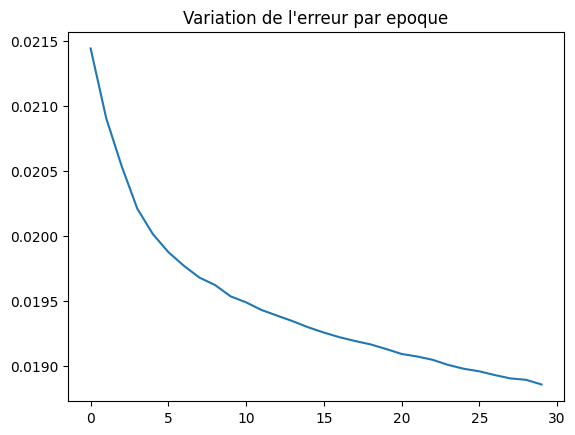

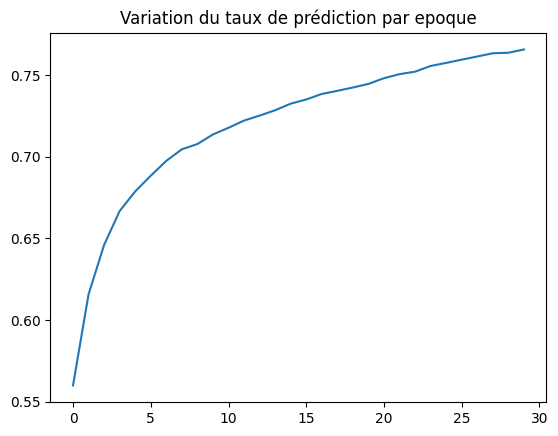

In [4]:
criterion = nn.BCEWithLogitsLoss()
epochs = 30
sgd = optim.Adam(auto_co.parameters(), lr=1e-2)

losses = []
accuracies = []
for epoch in range(epochs):
    train_loss = 0
    train_accuracy = 0
    auto_co.eval()
    latent_dis.train()
    for (X, y) in tqdm(train_loader, desc=f"Epoch : {epoch}"):
        X = 2 * X - 1
        X, y = X.to(device), y.to(device)
        sgd.zero_grad()
        z = auto_co.encoder(X)
        y_pred = latent_dis(z)
        probs = torch.sigmoid(y_pred)  # Conversion logits → probabilités
        pred = probs > 0.5
        train_accuracy += pred.eq(y.view_as(pred)).sum().item()
        loss = criterion(y_pred, y)
        train_loss += loss.item()
        loss.backward()
        sgd.step()
    accuracies.append(train_accuracy / (40*len(train_loader.dataset)))
    losses.append(train_loss / len(train_loader.dataset))

plt.plot(losses)
plt.title("Variation de l'erreur par epoque")
plt.show()

plt.plot(accuracies)
plt.title("Variation du taux de prédiction par epoque")
plt.show()

In [5]:
test_loss = 0
correct = 0

# pour ne aps calculer les gradients (gain de temps et de mémoire)
with torch.no_grad():
    for data, target in tqdm(test_loader):
        data = 2 * data - 1
        data, target = data.to(device), target.to(device)
        z = auto_co.encoder(data)
        y_pred = latent_dis(z)
        test_loss += criterion(y_pred, target).item()
        probs = torch.sigmoid(y_pred)  # Conversion logits → probabilités
        pred = probs > 0.5
        correct += pred.eq(target.view_as(pred)).sum().item()/40


test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {:.0f}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

100%|███████████████████████████████████████████| 79/79 [01:06<00:00,  1.20it/s]


Test set: Average loss: 0.0195, Accuracy: 1802/2500 (72%)



In [6]:
valid_loss = 0
correct = 0

# pour ne aps calculer les gradients (gain de temps et de mémoire)
with torch.no_grad():
    for data, target in tqdm(valid_loader):
        data = 2 * data - 1
        data, target = data.to(device), target.to(device)
        z = auto_co.encoder(data)
        y_pred = latent_dis(z)
        valid_loss += criterion(y_pred, target).item()
        probs = torch.sigmoid(y_pred)  # Conversion logits → probabilités
        pred = probs > 0.5
        correct += pred.eq(target.view_as(pred)).sum().item()/40


valid_loss /= len(valid_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {:.0f}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(valid_loader.dataset),
    100. * correct / len(valid_loader.dataset)))

100%|███████████████████████████████████████████| 79/79 [01:05<00:00,  1.20it/s]


Test set: Average loss: 0.0195, Accuracy: 1811/2500 (72%)

